In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install bitsandbytes accelerate transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 33.9 MB/s eta 0:00:00


In [3]:
import sys
import os
from typing import List, Tuple, Optional, Dict

from langchain_core.prompts import ChatPromptTemplate
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
import torch
from transformers import pipeline
import torch.nn as nn
from sentence_transformers import SentenceTransformer, util

2026-02-14 19:21:57.147937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771096917.332718      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771096917.387805      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771096917.799714      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771096917.799753      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771096917.799756      24 computation_placer.cc:177] computation placer alr

In [4]:
"""
Complete Training Pipeline - All Issues Fixed
Extracts features from IBM dataset and prepares training data
"""

import sys
import os
from typing import List, Tuple, Optional, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig,
    pipeline
)
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import gc
from tqdm import tqdm
from collections import Counter
import re


# ============================================================
# Model Provider
# ============================================================

class ModelProvider:
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    def load(self):
        print(f"📥 Loading tokenizer: {self.model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        print("⚡ Enabling 4-bit quantization...")
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        )
        
        print("🧠 Loading model...")
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        
        print(f"✅ Model loaded on: {self.model.device}")
        return self
    
    def generate_with_logprobs(
        self, 
        prompt: str, 
        max_new_tokens: int = 40, 
        temperature: float = 0.7
    ):
        """Generate with logprobs and entropy"""
        
        # Clear cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
        
        inputs = self.tokenizer(prompt, return_tensors="pt")
        input_ids = inputs["input_ids"].to(self.model.device)
        input_len = input_ids.shape[1]
        
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                do_sample=True,
                return_dict_in_generate=True,
                output_scores=True,
                pad_token_id=self.tokenizer.pad_token_id
            )
        
        sequences = outputs.sequences[0]
        scores = outputs.scores
        
        # Decode
        full_text = self.tokenizer.decode(sequences, skip_special_tokens=True)
        decoded_prompt = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        generated_text = full_text.replace(decoded_prompt, "").strip()
        
        # Compute logprobs and entropy
        logprobs = []
        entropies = []
        gen_token_ids = sequences[input_len:]
        
        for step_logits, token_id in zip(scores, gen_token_ids):
            logits = step_logits[0]
            
            # Logprob
            step_logprobs = F.log_softmax(logits, dim=-1)
            logprobs.append(step_logprobs[token_id].item())
            
            # Entropy
            probs = F.softmax(logits, dim=-1)
            entropy = -(probs * torch.log(probs + 1e-9)).sum()
            entropies.append(entropy.item())
        
        avg_logprob = sum(logprobs) / len(logprobs) if logprobs else 0.0
        max_logprob = max(logprobs) if logprobs else 0.0
        min_logprob = min(logprobs) if logprobs else 0.0
        avg_entropy = sum(entropies) / len(entropies) if entropies else 0.0
        
        return {
            "text": generated_text,
            "logprobs": logprobs,
            "avg_logprob": avg_logprob,
            "max_logprob": max_logprob,
            "min_logprob": min_logprob,
            "entropies": entropies,
            "avg_entropy": avg_entropy
        }


# ============================================================
# Helper Functions
# ============================================================

def nli_relevance_check(nli_pipeline, premise: str, hypothesis: str) -> Dict:
    """Check NLI relationship"""
    result = nli_pipeline(f"{premise} [SEP] {hypothesis}")
    return {
        "label": result[0]['label'],
        "score": result[0]['score']
    }


def calculate_repetition_score(text: str, n: int = 3) -> float:
    """
    Compute n-gram repetition score
    
    Returns:
        score in [0,1] where 0=no repetition, 1=extreme repetition
    """
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)
    
    if len(tokens) < n:
        return 0.0
    
    # Build n-grams
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
    
    if len(ngrams) == 0:
        return 0.0
    
    counts = Counter(ngrams)
    total_ngrams = len(ngrams)
    repeated_ngrams = sum(freq - 1 for freq in counts.values() if freq > 1)
    
    score = repeated_ngrams / total_ngrams
    return float(score)


def similarity_check(similarity_model, text1: str, text2: str) -> float:
    """Compute semantic similarity"""
    embeddings = similarity_model.encode([text1, text2], convert_to_tensor=True)
    cosine_score = util.cos_sim(embeddings[0], embeddings[1])
    scaled_score = (cosine_score.item() + 1) / 2
    return scaled_score


def supporting_argument_node(state: Dict, model_provider) -> Dict:
    """Generate supporting argument"""
    topic = state["topic"]
    
    prompt = f"""You are a skilled debater. Generate a strong supporting argument for this topic.

Topic: {topic}

Generate a clear, logical argument IN SUPPORT of this topic.

Argument:"""
    
    result = model_provider.generate_with_logprobs(prompt)
    
    return {
        "argument": result["text"],
        "logprobs": result["logprobs"],
        "avg_logprob": result["avg_logprob"],
        "max_logprob": result.get("max_logprob", 0.0),
        "min_logprob": result.get("min_logprob", 0.0),
        "avg_entropy": result.get("avg_entropy", 0.0)
    }


def opposing_argument_node(state: Dict, model_provider) -> Dict:
    """Generate opposing argument"""
    topic = state["topic"]
    
    prompt = f"""You are a skilled debater. Generate a strong opposing argument for this topic.

Topic: {topic}

Generate a clear, logical argument AGAINST this topic.

Argument:"""
    
    result = model_provider.generate_with_logprobs(prompt)
    
    return {
        "argument": result["text"],
        "logprobs": result["logprobs"],
        "avg_logprob": result["avg_logprob"]
    }


# ============================================================
# Confidence Score Calculator
# ============================================================

HEDGING_WORDS = {
    'strong': {
        'may be', 'might be', 'could be', 'would be', 'perhaps', 'possibly',
        'maybe', 'uncertain', 'unclear', 'questionable', 'debatable',
        'arguably', 'supposedly', 'allegedly', 'presumably', 'conceivably',
        'potentially', 'seems like', 'appears to be', 'looks like',
        'i think', 'i believe', 'i guess', 'i suppose', 'in my opinion',
        'not sure', 'unsure', 'doubt', 'speculation', 'speculative'
    },
    'moderate': {
        'likely', 'probably', 'generally', 'typically', 'usually',
        'often', 'sometimes', 'occasionally', 'frequently', 'tend to',
        'appear to', 'seem to', 'suggest', 'indicate', 'imply',
        'somewhat', 'rather', 'quite', 'fairly', 'relatively',
        'to some extent', 'to a degree', 'in some ways', 'partially',
        'might', 'could', 'would', 'should', 'may'
    },
    'weak': {
        'possible', 'feasible', 'plausible', 'reasonable', 'viable',
        'can', 'will', 'shall', 'mostly', 'largely',
        'predominantly', 'mainly', 'chiefly', 'primarily'
    }
}

CONFIDENCE_BOOSTERS = {
    'certainly', 'definitely', 'absolutely', 'clearly', 'obviously',
    'undoubtedly', 'unquestionably', 'indisputably', 'surely', 'indeed',
    'proven', 'demonstrated', 'established', 'confirmed', 'verified',
    'conclusively', 'decidedly', 'precisely', 'exactly', 'specifically',
    'must', 'will', 'always', 'never', 'all', 'none', 'every',
    'inevitable', 'certain', 'guaranteed', 'assured', 'definite',
    'fact', 'facts', 'evidence shows', 'research proves', 'studies show'
}

QUALIFIERS = {
    'kind of', 'sort of', 'a bit', 'a little', 'slightly', 'somewhat',
    'more or less', 'in a sense', 'in a way', 'so to speak',
    'basically', 'essentially', 'roughly', 'approximately', 'around'
}

QUESTION_MARKERS = {
    'is it', 'are there', 'could it be', 'might it be', 'what if',
    'how can', 'why would', 'who knows', 'remains to be seen'
}


def _count_phrases(text: str, phrase_set: set) -> int:
    """Count occurrences of phrases in text"""
    count = 0
    for phrase in phrase_set:
        pattern = r'\b' + re.escape(phrase) + r'\b'
        count += len(re.findall(pattern, text))
    return count


def calculate_confidence_score(text: str) -> Dict[str, float]:
    """Calculate confidence score based on linguistic markers"""
    text_lower = text.lower()
    words = text_lower.split()
    total_words = len(words)
    
    if total_words == 0:
        return {'confidence_score': 0.5, 'details': {}}
    
    # Count markers
    strong_hedge_count = _count_phrases(text_lower, HEDGING_WORDS['strong'])
    moderate_hedge_count = _count_phrases(text_lower, HEDGING_WORDS['moderate'])
    weak_hedge_count = _count_phrases(text_lower, HEDGING_WORDS['weak'])
    
    booster_count = _count_phrases(text_lower, CONFIDENCE_BOOSTERS)
    qualifier_count = _count_phrases(text_lower, QUALIFIERS)
    question_count = _count_phrases(text_lower, QUESTION_MARKERS)
    
    # Calculate scores
    hedge_score = (
        strong_hedge_count * 3.0 +
        moderate_hedge_count * 2.0 +
        weak_hedge_count * 1.0 +
        qualifier_count * 1.5 +
        question_count * 2.0
    )
    
    normalized_hedge_score = (hedge_score / total_words) * 100
    normalized_booster_score = (booster_count / total_words) * 100
    
    base_confidence = 0.5
    hedge_penalty = min(normalized_hedge_score * 0.05, 0.4)
    booster_bonus = min(normalized_booster_score * 0.1, 0.4)
    
    confidence_score = base_confidence - hedge_penalty + booster_bonus
    confidence_score = max(0.0, min(1.0, confidence_score))
    
    details = {
        'strong_hedges': strong_hedge_count,
        'moderate_hedges': moderate_hedge_count,
        'weak_hedges': weak_hedge_count,
        'confidence_boosters': booster_count,
        'hedge_penalty': hedge_penalty,
        'booster_bonus': booster_bonus
    }
    
    return {
        'confidence_score': confidence_score,
        'details': details
    }


# ============================================================
# Feature Extractor
# ============================================================

class FeatureExtractor:
    """Extract features for training"""
    
    def __init__(self):
        self.device_id = 0 if torch.cuda.is_available() else -1
        self.device_str = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"🚀 FeatureExtractor using device: {self.device_str}")
        
        print("📦 Loading NLI pipeline...")
        self.nli_pipeline = pipeline(
            "text-classification",
            model="facebook/bart-large-mnli",
            device=self.device_id
        )
        
        print("📦 Loading similarity model...")
        self.similarity_model = SentenceTransformer(
            "all-MiniLM-L6-v2",
            device=self.device_str
        )
        
        print("📦 Initializing Model Provider...")
        self.model_provider = ModelProvider(
            model_name="mistralai/Mistral-7B-Instruct-v0.1"
        )
        print("📥 Loading Model Weights & Tokenizer...")
        self.model_provider.load()
        
        print("✅ FeatureExtractor ready!")
    
    def extract_features(self, topic: str) -> Dict:
        """Extract all features for a topic"""
        
        # Generate arguments
        supporting_result = supporting_argument_node(
            {"topic": topic},
            self.model_provider
        )
        
        opposing_result = opposing_argument_node(
            {"topic": topic},
            self.model_provider
        )
        
        argument = supporting_result["argument"]
        opposing_argument = opposing_result["argument"]
        
        # Logprob features
        avg_logprob = supporting_result["avg_logprob"]
        max_logprob = supporting_result.get("max_logprob", 0.0)
        min_logprob = supporting_result.get("min_logprob", 0.0)
        avg_entropy = supporting_result.get("avg_entropy", 0.0)
        
        # NLI features
        relevance_result = nli_relevance_check(
            self.nli_pipeline,
            topic,
            argument
        )
        
        if relevance_result["label"] == "ENTAILMENT":
            relevance_score_support = relevance_result["score"]
        elif relevance_result["label"] == "CONTRADICTION":
            relevance_score_support = 0.0
        else:
            relevance_score_support = 1 - relevance_result["score"]
        
        relevance_result2 = nli_relevance_check(
            self.nli_pipeline,
            argument,
            opposing_argument
        )
        
        if relevance_result2["label"] == "ENTAILMENT":
            relevance_score_contra = 1 - relevance_result2["score"]
        elif relevance_result2["label"] == "NEUTRAL":
            relevance_score_contra = 0.5
        else:
            relevance_score_contra = relevance_result2["score"]
        
        # Semantic similarity
        similarity_score = similarity_check(
            self.similarity_model,
            topic,
            argument
        )
        
        # Confidence and repetition
        confidence_result = calculate_confidence_score(argument)
        confidence_score = confidence_result['confidence_score']
        
        repetition_score = calculate_repetition_score(argument)
        
        return {
            "avg_logprob": avg_logprob,
            "max_logprob": max_logprob,
            "min_logprob": min_logprob,
            "avg_entropy": avg_entropy,
            "relevance_score_support": relevance_score_support,
            "relevance_score_contra": relevance_score_contra,
            "similarity_score": similarity_score,
            "confidence_score": confidence_score,
            "repitition_score": repetition_score
        }


# ============================================================
# Data Preparation
# ============================================================

def prepare_data(
    dataset,
    feature_extractor: FeatureExtractor,
    max_samples: int = 1000,
    save_path: Optional[str] = "training_data.pt",
    start_idx: int = 0
) -> List[Tuple[torch.Tensor, float]]:
    """Prepare training data with resume support"""
    
    # Resume logic
    if start_idx > 0 and os.path.exists(save_path):
        training_data = torch.load(save_path)
        print(f"🔁 Loaded checkpoint with {len(training_data)} samples")
    else:
        training_data = []
        print("🆕 Starting fresh dataset")
    
    print(f"\n🔧 Processing samples {start_idx} → {max_samples}")
    
    for i in tqdm(range(start_idx, min(max_samples, len(dataset)))):
        try:
            entry = dataset[i]
            
            topic = entry.get("topic", "")
            if not topic:
                print(f"⚠️ Skipping {i}: no topic")
                continue
            
            # Extract features
            features_dict = feature_extractor.extract_features(topic)
            
            # Create feature tensor (4 features for now)
            features = torch.tensor([
                features_dict["avg_logprob"],
                features_dict["relevance_score_support"],
                features_dict["relevance_score_contra"],
                features_dict["similarity_score"],
                features_dict["confidence_score"],
                features_dict["repitition_score"],
                features_dict["max_logprob"],
                features_dict["min_logprob"],
                features_dict["avg_entropy"]
                
            ], dtype=torch.float32)
            
            # Ground truth: (WA * stance_WA + 1) / 2 to normalize to [0,1]
            wa = entry.get("WA", 0.5)
            stance_wa = entry.get("stance_WA", 0.5)
            truth_score = ((wa * stance_wa) + 1) / 2.0
            
            training_data.append((features, truth_score))
            
            # Logging
            if (i + 1) % 25 == 0:
                print(f"\n✅ Processed {i+1}/{max_samples}")
                print(f"   Topic: {topic[:50]}...")
                print(f"   Label: {truth_score:.3f}")
            
            # Checkpoint save
            if (i + 1) % 3 == 0 and save_path:
                torch.save(training_data, save_path)
                print(f"💾 Checkpoint @ {i+1}")
        
        except Exception as e:
            print(f"\n❌ Error at {i}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Final save
    if save_path:
        torch.save(training_data, save_path)
        print(f"\n💾 Final save → {save_path}")
    
    print(f"✅ Total samples: {len(training_data)}")
    
    return training_data


# ============================================================
# Main Execution
# ============================================================

if __name__ == "__main__":
    
    print("🧠 Training Data Preparation Pipeline")
    print("=" * 80)
    
    # Load dataset
    print("\n📦 Loading IBM dataset...")
    try:
        ds = load_dataset(
            "ibm-research/argument_quality_ranking_30k",
            "argument_quality_ranking"
        )
        print("✅ Dataset loaded!")
        print(f"   Train: {len(ds['train'])} samples")
        print(f"   Validation: {len(ds['validation'])} samples")
    except Exception as e:
        print(f"❌ Error: {e}")
        print("💡 Run: huggingface-cli login")
        exit(1)
    
    # Initialize
    print("\n🔧 Initializing Feature Extractor...")
    feature_extractor = FeatureExtractor()
    
    # Prepare data
    print("\n📝 Starting data preparation...")
    
    training_data = prepare_data(
        dataset=ds["train"],
        feature_extractor=feature_extractor,
        max_samples=1000,  # Start small
        save_path="training_data.pt",
        start_idx=0
    )
    
    # Analyze
    if training_data:
        features = torch.stack([item[0] for item in training_data])
        labels = torch.tensor([item[1] for item in training_data])
        
        print("\n📊 Data Statistics:")
        print(f"   Samples: {len(training_data)}")
        print(f"\n   Feature Means:")
        print(f"      Logprob: {features[:, 0].mean():.3f}")
        print(f"      Relevance (Support): {features[:, 1].mean():.3f}")
        print(f"      Relevance (Contra): {features[:, 2].mean():.3f}")
        print(f"      Similarity: {features[:, 3].mean():.3f}")
        print(f"\n   Label Statistics:")
        print(f"      Mean: {labels.mean():.3f}")
        print(f"      Std: {labels.std():.3f}")
        print(f"      Min: {labels.min():.3f}")
        print(f"      Max: {labels.max():.3f}")
    
    print("\n✅ COMPLETE!")

🧠 Training Data Preparation Pipeline

📦 Loading IBM dataset...


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

dev.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/20974 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3208 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6315 [00:00<?, ? examples/s]

✅ Dataset loaded!
   Train: 20974 samples
   Validation: 3208 samples

🔧 Initializing Feature Extractor...
🚀 FeatureExtractor using device: cuda
📦 Loading NLI pipeline...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


📦 Loading similarity model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

📦 Initializing Model Provider...
📥 Loading Model Weights & Tokenizer...
📥 Loading tokenizer: mistralai/Mistral-7B-Instruct-v0.1


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

⚡ Enabling 4-bit quantization...
🧠 Loading model...


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

✅ Model loaded on: cuda:0
✅ FeatureExtractor ready!

📝 Starting data preparation...
🆕 Starting fresh dataset

🔧 Processing samples 0 → 1000


  0%|          | 3/1000 [00:26<2:23:08,  8.61s/it]

💾 Checkpoint @ 3


  1%|          | 6/1000 [00:51<2:19:38,  8.43s/it]

💾 Checkpoint @ 6


  1%|          | 9/1000 [01:16<2:18:32,  8.39s/it]

💾 Checkpoint @ 9


  1%|          | 12/1000 [01:41<2:18:08,  8.39s/it]

💾 Checkpoint @ 12


  2%|▏         | 15/1000 [02:06<2:17:32,  8.38s/it]

💾 Checkpoint @ 15


  2%|▏         | 18/1000 [02:31<2:17:11,  8.38s/it]

💾 Checkpoint @ 18


  2%|▏         | 21/1000 [02:56<2:16:31,  8.37s/it]

💾 Checkpoint @ 21


  2%|▏         | 24/1000 [03:22<2:16:11,  8.37s/it]

💾 Checkpoint @ 24


  2%|▎         | 25/1000 [03:30<2:15:50,  8.36s/it]


✅ Processed 25/1000
   Topic: We should introduce compulsory voting...
   Label: 0.820


  3%|▎         | 27/1000 [03:47<2:16:07,  8.39s/it]

💾 Checkpoint @ 27


  3%|▎         | 30/1000 [04:12<2:15:24,  8.38s/it]

💾 Checkpoint @ 30


  3%|▎         | 33/1000 [04:37<2:14:48,  8.36s/it]

💾 Checkpoint @ 33


  4%|▎         | 36/1000 [05:02<2:13:56,  8.34s/it]

💾 Checkpoint @ 36


  4%|▍         | 39/1000 [05:27<2:13:48,  8.35s/it]

💾 Checkpoint @ 39


  4%|▍         | 42/1000 [05:52<2:13:35,  8.37s/it]

💾 Checkpoint @ 42


  4%|▍         | 45/1000 [06:17<2:12:45,  8.34s/it]

💾 Checkpoint @ 45


  5%|▍         | 48/1000 [06:42<2:12:32,  8.35s/it]

💾 Checkpoint @ 48


  5%|▌         | 50/1000 [06:59<2:12:07,  8.35s/it]


✅ Processed 50/1000
   Topic: We should subsidize Wikipedia...
   Label: 0.000


  5%|▌         | 51/1000 [07:07<2:12:17,  8.36s/it]

💾 Checkpoint @ 51


  5%|▌         | 54/1000 [07:32<2:11:30,  8.34s/it]

💾 Checkpoint @ 54


  6%|▌         | 57/1000 [07:57<2:11:02,  8.34s/it]

💾 Checkpoint @ 57


  6%|▌         | 60/1000 [08:22<2:10:54,  8.36s/it]

💾 Checkpoint @ 60


  6%|▋         | 63/1000 [08:47<2:10:58,  8.39s/it]

💾 Checkpoint @ 63


  7%|▋         | 66/1000 [09:13<2:10:37,  8.39s/it]

💾 Checkpoint @ 66


  7%|▋         | 69/1000 [09:38<2:09:53,  8.37s/it]

💾 Checkpoint @ 69


  7%|▋         | 72/1000 [10:03<2:09:51,  8.40s/it]

💾 Checkpoint @ 72


  8%|▊         | 75/1000 [10:28<2:08:42,  8.35s/it]


✅ Processed 75/1000
   Topic: We should oppose collectivism...
   Label: 0.128
💾 Checkpoint @ 75


  8%|▊         | 78/1000 [10:53<2:08:33,  8.37s/it]

💾 Checkpoint @ 78


  8%|▊         | 81/1000 [11:18<2:08:03,  8.36s/it]

💾 Checkpoint @ 81


  8%|▊         | 84/1000 [11:43<2:07:10,  8.33s/it]

💾 Checkpoint @ 84


  9%|▊         | 87/1000 [12:08<2:06:54,  8.34s/it]

💾 Checkpoint @ 87


  9%|▉         | 90/1000 [12:33<2:06:53,  8.37s/it]

💾 Checkpoint @ 90


  9%|▉         | 93/1000 [12:58<2:06:36,  8.37s/it]

💾 Checkpoint @ 93


 10%|▉         | 96/1000 [13:23<2:06:06,  8.37s/it]

💾 Checkpoint @ 96


 10%|▉         | 99/1000 [13:49<2:06:01,  8.39s/it]

💾 Checkpoint @ 99


 10%|█         | 100/1000 [13:57<2:05:48,  8.39s/it]


✅ Processed 100/1000
   Topic: We should ban cosmetic surgery for minors...
   Label: 0.924


 10%|█         | 102/1000 [14:14<2:05:52,  8.41s/it]

💾 Checkpoint @ 102


 10%|█         | 105/1000 [14:39<2:04:52,  8.37s/it]

💾 Checkpoint @ 105


 11%|█         | 108/1000 [15:04<2:04:29,  8.37s/it]

💾 Checkpoint @ 108


 11%|█         | 111/1000 [15:29<2:03:59,  8.37s/it]

💾 Checkpoint @ 111


 11%|█▏        | 114/1000 [15:54<2:03:28,  8.36s/it]

💾 Checkpoint @ 114


 12%|█▏        | 117/1000 [16:19<2:03:01,  8.36s/it]

💾 Checkpoint @ 117


 12%|█▏        | 120/1000 [16:45<2:03:01,  8.39s/it]

💾 Checkpoint @ 120


 12%|█▏        | 123/1000 [17:10<2:02:22,  8.37s/it]

💾 Checkpoint @ 123


 12%|█▎        | 125/1000 [17:26<2:01:55,  8.36s/it]


✅ Processed 125/1000
   Topic: We should adopt a multi-party system...
   Label: 0.986


 13%|█▎        | 126/1000 [17:35<2:01:55,  8.37s/it]

💾 Checkpoint @ 126


 13%|█▎        | 129/1000 [18:00<2:01:25,  8.37s/it]

💾 Checkpoint @ 129


 13%|█▎        | 132/1000 [18:25<2:00:50,  8.35s/it]

💾 Checkpoint @ 132


 14%|█▎        | 135/1000 [18:50<2:00:53,  8.39s/it]

💾 Checkpoint @ 135


 14%|█▍        | 138/1000 [19:15<2:00:26,  8.38s/it]

💾 Checkpoint @ 138


 14%|█▍        | 141/1000 [19:40<2:00:02,  8.38s/it]

💾 Checkpoint @ 141


 14%|█▍        | 144/1000 [20:05<1:59:21,  8.37s/it]

💾 Checkpoint @ 144


 15%|█▍        | 147/1000 [20:30<1:58:53,  8.36s/it]

💾 Checkpoint @ 147


 15%|█▌        | 150/1000 [20:55<1:58:21,  8.36s/it]


✅ Processed 150/1000
   Topic: We should adopt a multi-party system...
   Label: 0.941
💾 Checkpoint @ 150


 15%|█▌        | 153/1000 [21:20<1:57:53,  8.35s/it]

💾 Checkpoint @ 153


 16%|█▌        | 156/1000 [21:45<1:56:58,  8.32s/it]

💾 Checkpoint @ 156


 16%|█▌        | 159/1000 [22:10<1:57:03,  8.35s/it]

💾 Checkpoint @ 159


 16%|█▌        | 162/1000 [22:35<1:56:21,  8.33s/it]

💾 Checkpoint @ 162


 16%|█▋        | 165/1000 [23:00<1:55:45,  8.32s/it]

💾 Checkpoint @ 165


 17%|█▋        | 168/1000 [23:25<1:55:47,  8.35s/it]

💾 Checkpoint @ 168


 17%|█▋        | 171/1000 [23:51<1:55:31,  8.36s/it]

💾 Checkpoint @ 171


 17%|█▋        | 174/1000 [24:15<1:54:47,  8.34s/it]

💾 Checkpoint @ 174


 18%|█▊        | 175/1000 [24:24<1:54:25,  8.32s/it]


✅ Processed 175/1000
   Topic: We should adopt a multi-party system...
   Label: 0.031


 18%|█▊        | 177/1000 [24:40<1:54:32,  8.35s/it]

💾 Checkpoint @ 177


 18%|█▊        | 180/1000 [25:06<1:54:02,  8.34s/it]

💾 Checkpoint @ 180


 18%|█▊        | 183/1000 [25:30<1:53:12,  8.31s/it]

💾 Checkpoint @ 183


 19%|█▊        | 186/1000 [25:55<1:52:46,  8.31s/it]

💾 Checkpoint @ 186


 19%|█▉        | 189/1000 [26:20<1:52:57,  8.36s/it]

💾 Checkpoint @ 189


 19%|█▉        | 192/1000 [26:45<1:52:19,  8.34s/it]

💾 Checkpoint @ 192


 20%|█▉        | 195/1000 [27:10<1:51:26,  8.31s/it]

💾 Checkpoint @ 195


 20%|█▉        | 198/1000 [27:35<1:50:47,  8.29s/it]

💾 Checkpoint @ 198


 20%|██        | 200/1000 [27:52<1:50:22,  8.28s/it]


✅ Processed 200/1000
   Topic: We should adopt a multi-party system...
   Label: 0.069


 20%|██        | 201/1000 [28:00<1:50:23,  8.29s/it]

💾 Checkpoint @ 201


 20%|██        | 204/1000 [28:25<1:49:59,  8.29s/it]

💾 Checkpoint @ 204


 21%|██        | 207/1000 [28:50<1:50:00,  8.32s/it]

💾 Checkpoint @ 207


 21%|██        | 210/1000 [29:15<1:49:25,  8.31s/it]

💾 Checkpoint @ 210


 21%|██▏       | 213/1000 [29:40<1:49:35,  8.35s/it]

💾 Checkpoint @ 213


 22%|██▏       | 216/1000 [30:05<1:49:14,  8.36s/it]

💾 Checkpoint @ 216


 22%|██▏       | 219/1000 [30:30<1:48:25,  8.33s/it]

💾 Checkpoint @ 219


 22%|██▏       | 222/1000 [30:55<1:47:33,  8.29s/it]

💾 Checkpoint @ 222


 22%|██▎       | 225/1000 [31:20<1:47:27,  8.32s/it]


✅ Processed 225/1000
   Topic: We should adopt a multi-party system...
   Label: 0.947
💾 Checkpoint @ 225


 23%|██▎       | 228/1000 [31:45<1:46:49,  8.30s/it]

💾 Checkpoint @ 228


 23%|██▎       | 231/1000 [32:09<1:46:11,  8.29s/it]

💾 Checkpoint @ 231


 23%|██▎       | 234/1000 [32:34<1:45:53,  8.29s/it]

💾 Checkpoint @ 234


 24%|██▎       | 237/1000 [32:59<1:45:54,  8.33s/it]

💾 Checkpoint @ 237


 24%|██▍       | 240/1000 [33:24<1:45:32,  8.33s/it]

💾 Checkpoint @ 240


 24%|██▍       | 243/1000 [33:49<1:45:06,  8.33s/it]

💾 Checkpoint @ 243


 25%|██▍       | 246/1000 [34:14<1:44:48,  8.34s/it]

💾 Checkpoint @ 246


 25%|██▍       | 249/1000 [34:39<1:44:02,  8.31s/it]

💾 Checkpoint @ 249


 25%|██▌       | 250/1000 [34:48<1:44:07,  8.33s/it]


✅ Processed 250/1000
   Topic: We should abolish the right to keep and bear arms...
   Label: 0.301


 25%|██▌       | 252/1000 [35:04<1:44:04,  8.35s/it]

💾 Checkpoint @ 252


 26%|██▌       | 255/1000 [35:29<1:43:29,  8.33s/it]

💾 Checkpoint @ 255


 26%|██▌       | 258/1000 [35:54<1:42:52,  8.32s/it]

💾 Checkpoint @ 258


 26%|██▌       | 261/1000 [36:19<1:42:10,  8.30s/it]

💾 Checkpoint @ 261


 26%|██▋       | 264/1000 [36:44<1:41:51,  8.30s/it]

💾 Checkpoint @ 264


 27%|██▋       | 267/1000 [37:09<1:41:24,  8.30s/it]

💾 Checkpoint @ 267


 27%|██▋       | 270/1000 [37:34<1:40:46,  8.28s/it]

💾 Checkpoint @ 270


 27%|██▋       | 273/1000 [37:59<1:41:09,  8.35s/it]

💾 Checkpoint @ 273


 28%|██▊       | 275/1000 [38:16<1:40:48,  8.34s/it]


✅ Processed 275/1000
   Topic: We should abolish safe spaces...
   Label: 0.177


 28%|██▊       | 276/1000 [38:24<1:40:35,  8.34s/it]

💾 Checkpoint @ 276


 28%|██▊       | 279/1000 [38:49<1:40:12,  8.34s/it]

💾 Checkpoint @ 279


 28%|██▊       | 282/1000 [39:14<1:39:45,  8.34s/it]

💾 Checkpoint @ 282


 28%|██▊       | 285/1000 [39:39<1:39:11,  8.32s/it]

💾 Checkpoint @ 285


 29%|██▉       | 288/1000 [40:04<1:38:54,  8.34s/it]

💾 Checkpoint @ 288


 29%|██▉       | 291/1000 [40:29<1:38:08,  8.31s/it]

💾 Checkpoint @ 291


 29%|██▉       | 294/1000 [40:54<1:37:55,  8.32s/it]

💾 Checkpoint @ 294


 30%|██▉       | 297/1000 [41:19<1:37:39,  8.34s/it]

💾 Checkpoint @ 297


 30%|███       | 300/1000 [41:44<1:37:06,  8.32s/it]


✅ Processed 300/1000
   Topic: We should stop the development of autonomous cars...
   Label: 0.138
💾 Checkpoint @ 300


 30%|███       | 303/1000 [42:09<1:36:44,  8.33s/it]

💾 Checkpoint @ 303


 31%|███       | 306/1000 [42:34<1:36:05,  8.31s/it]

💾 Checkpoint @ 306


 31%|███       | 309/1000 [42:59<1:35:42,  8.31s/it]

💾 Checkpoint @ 309


 31%|███       | 312/1000 [43:24<1:35:53,  8.36s/it]

💾 Checkpoint @ 312


 32%|███▏      | 315/1000 [43:49<1:34:57,  8.32s/it]

💾 Checkpoint @ 315


 32%|███▏      | 318/1000 [44:13<1:34:11,  8.29s/it]

💾 Checkpoint @ 318


 32%|███▏      | 321/1000 [44:38<1:33:45,  8.28s/it]

💾 Checkpoint @ 321


 32%|███▏      | 324/1000 [45:03<1:33:50,  8.33s/it]

💾 Checkpoint @ 324


 32%|███▎      | 325/1000 [45:12<1:33:59,  8.35s/it]


✅ Processed 325/1000
   Topic: We should abolish zoos...
   Label: 0.956


 33%|███▎      | 327/1000 [45:28<1:33:10,  8.31s/it]

💾 Checkpoint @ 327


 33%|███▎      | 330/1000 [45:53<1:33:04,  8.34s/it]

💾 Checkpoint @ 330


 33%|███▎      | 333/1000 [46:18<1:32:41,  8.34s/it]

💾 Checkpoint @ 333


 34%|███▎      | 336/1000 [46:43<1:31:58,  8.31s/it]

💾 Checkpoint @ 336


 34%|███▍      | 339/1000 [47:08<1:31:30,  8.31s/it]

💾 Checkpoint @ 339


 34%|███▍      | 342/1000 [47:33<1:31:00,  8.30s/it]

💾 Checkpoint @ 342


 34%|███▍      | 345/1000 [47:58<1:30:49,  8.32s/it]

💾 Checkpoint @ 345


 35%|███▍      | 348/1000 [48:23<1:30:24,  8.32s/it]

💾 Checkpoint @ 348


 35%|███▌      | 350/1000 [48:40<1:29:57,  8.30s/it]


✅ Processed 350/1000
   Topic: We should abolish the right to keep and bear arms...
   Label: 0.283


 35%|███▌      | 351/1000 [48:48<1:30:08,  8.33s/it]

💾 Checkpoint @ 351


 35%|███▌      | 354/1000 [49:13<1:29:42,  8.33s/it]

💾 Checkpoint @ 354


 36%|███▌      | 357/1000 [49:38<1:29:06,  8.31s/it]

💾 Checkpoint @ 357


 36%|███▌      | 360/1000 [50:03<1:28:42,  8.32s/it]

💾 Checkpoint @ 360


 36%|███▋      | 363/1000 [50:28<1:28:48,  8.37s/it]

💾 Checkpoint @ 363


 37%|███▋      | 366/1000 [50:53<1:28:29,  8.38s/it]

💾 Checkpoint @ 366


 37%|███▋      | 369/1000 [51:18<1:28:11,  8.39s/it]

💾 Checkpoint @ 369


 37%|███▋      | 372/1000 [51:43<1:27:38,  8.37s/it]

💾 Checkpoint @ 372


 38%|███▊      | 375/1000 [52:09<1:27:18,  8.38s/it]


✅ Processed 375/1000
   Topic: We should subsidize vocational education...
   Label: 1.000
💾 Checkpoint @ 375


 38%|███▊      | 378/1000 [52:34<1:26:26,  8.34s/it]

💾 Checkpoint @ 378


 38%|███▊      | 381/1000 [53:00<1:28:57,  8.62s/it]

💾 Checkpoint @ 381


 38%|███▊      | 384/1000 [53:26<1:29:18,  8.70s/it]

💾 Checkpoint @ 384


 39%|███▊      | 387/1000 [53:51<1:26:39,  8.48s/it]

💾 Checkpoint @ 387


 39%|███▉      | 390/1000 [54:16<1:24:51,  8.35s/it]

💾 Checkpoint @ 390


 39%|███▉      | 393/1000 [54:41<1:24:20,  8.34s/it]

💾 Checkpoint @ 393


 40%|███▉      | 396/1000 [55:06<1:23:46,  8.32s/it]

💾 Checkpoint @ 396


 40%|███▉      | 399/1000 [55:31<1:23:41,  8.36s/it]

💾 Checkpoint @ 399


 40%|████      | 400/1000 [55:39<1:23:23,  8.34s/it]


✅ Processed 400/1000
   Topic: We should legalize organ trade...
   Label: 0.958


 40%|████      | 402/1000 [55:56<1:23:24,  8.37s/it]

💾 Checkpoint @ 402


 40%|████      | 405/1000 [56:21<1:22:49,  8.35s/it]

💾 Checkpoint @ 405


 41%|████      | 408/1000 [56:46<1:22:12,  8.33s/it]

💾 Checkpoint @ 408


 41%|████      | 411/1000 [57:11<1:22:34,  8.41s/it]

💾 Checkpoint @ 411


 41%|████▏     | 414/1000 [57:36<1:21:44,  8.37s/it]

💾 Checkpoint @ 414


 42%|████▏     | 417/1000 [58:01<1:21:14,  8.36s/it]

💾 Checkpoint @ 417


 42%|████▏     | 420/1000 [58:27<1:20:42,  8.35s/it]

💾 Checkpoint @ 420


 42%|████▏     | 423/1000 [58:52<1:20:20,  8.36s/it]

💾 Checkpoint @ 423


 42%|████▎     | 425/1000 [59:08<1:20:19,  8.38s/it]


✅ Processed 425/1000
   Topic: We should adopt an austerity regime...
   Label: 0.070


 43%|████▎     | 426/1000 [59:17<1:20:07,  8.38s/it]

💾 Checkpoint @ 426


 43%|████▎     | 429/1000 [59:42<1:19:39,  8.37s/it]

💾 Checkpoint @ 429


 43%|████▎     | 432/1000 [1:00:07<1:19:17,  8.38s/it]

💾 Checkpoint @ 432


 44%|████▎     | 435/1000 [1:00:32<1:18:55,  8.38s/it]

💾 Checkpoint @ 435


 44%|████▍     | 438/1000 [1:00:57<1:18:34,  8.39s/it]

💾 Checkpoint @ 438


 44%|████▍     | 441/1000 [1:01:22<1:17:54,  8.36s/it]

💾 Checkpoint @ 441


 44%|████▍     | 444/1000 [1:01:47<1:16:43,  8.28s/it]

💾 Checkpoint @ 444


 45%|████▍     | 447/1000 [1:02:12<1:15:50,  8.23s/it]

💾 Checkpoint @ 447


 45%|████▌     | 450/1000 [1:02:36<1:15:36,  8.25s/it]


✅ Processed 450/1000
   Topic: We should ban the use of child actors...
   Label: 0.355
💾 Checkpoint @ 450


 45%|████▌     | 453/1000 [1:03:01<1:14:58,  8.22s/it]

💾 Checkpoint @ 453


 46%|████▌     | 456/1000 [1:03:26<1:14:26,  8.21s/it]

💾 Checkpoint @ 456


 46%|████▌     | 459/1000 [1:03:50<1:14:04,  8.22s/it]

💾 Checkpoint @ 459


 46%|████▌     | 462/1000 [1:04:15<1:13:35,  8.21s/it]

💾 Checkpoint @ 462


 46%|████▋     | 465/1000 [1:04:40<1:13:10,  8.21s/it]

💾 Checkpoint @ 465


 47%|████▋     | 468/1000 [1:05:04<1:12:51,  8.22s/it]

💾 Checkpoint @ 468


 47%|████▋     | 471/1000 [1:05:29<1:12:19,  8.20s/it]

💾 Checkpoint @ 471


 47%|████▋     | 474/1000 [1:05:54<1:12:08,  8.23s/it]

💾 Checkpoint @ 474


 48%|████▊     | 475/1000 [1:06:02<1:11:54,  8.22s/it]


✅ Processed 475/1000
   Topic: We should end affirmative action...
   Label: 0.853


 48%|████▊     | 477/1000 [1:06:18<1:11:30,  8.20s/it]

💾 Checkpoint @ 477


 48%|████▊     | 480/1000 [1:06:43<1:11:12,  8.22s/it]

💾 Checkpoint @ 480


 48%|████▊     | 483/1000 [1:07:07<1:10:46,  8.21s/it]

💾 Checkpoint @ 483


 49%|████▊     | 486/1000 [1:07:32<1:10:16,  8.20s/it]

💾 Checkpoint @ 486


 49%|████▉     | 489/1000 [1:07:57<1:09:54,  8.21s/it]

💾 Checkpoint @ 489


 49%|████▉     | 492/1000 [1:08:21<1:09:23,  8.20s/it]

💾 Checkpoint @ 492


 50%|████▉     | 495/1000 [1:08:46<1:09:09,  8.22s/it]

💾 Checkpoint @ 495


 50%|████▉     | 498/1000 [1:09:11<1:08:57,  8.24s/it]

💾 Checkpoint @ 498


 50%|█████     | 500/1000 [1:09:27<1:08:32,  8.22s/it]


✅ Processed 500/1000
   Topic: We should end affirmative action...
   Label: 0.000


 50%|█████     | 501/1000 [1:09:35<1:08:23,  8.22s/it]

💾 Checkpoint @ 501


 50%|█████     | 504/1000 [1:10:00<1:07:53,  8.21s/it]

💾 Checkpoint @ 504


 51%|█████     | 507/1000 [1:10:24<1:07:22,  8.20s/it]

💾 Checkpoint @ 507


 51%|█████     | 510/1000 [1:10:49<1:07:20,  8.25s/it]

💾 Checkpoint @ 510


 51%|█████▏    | 513/1000 [1:11:14<1:06:52,  8.24s/it]

💾 Checkpoint @ 513


 52%|█████▏    | 516/1000 [1:11:39<1:06:21,  8.23s/it]

💾 Checkpoint @ 516


 52%|█████▏    | 519/1000 [1:12:03<1:05:57,  8.23s/it]

💾 Checkpoint @ 519


 52%|█████▏    | 522/1000 [1:12:28<1:05:25,  8.21s/it]

💾 Checkpoint @ 522


 52%|█████▎    | 525/1000 [1:12:53<1:05:08,  8.23s/it]


✅ Processed 525/1000
   Topic: We should end affirmative action...
   Label: 0.166
💾 Checkpoint @ 525


 53%|█████▎    | 528/1000 [1:13:17<1:04:42,  8.23s/it]

💾 Checkpoint @ 528


 53%|█████▎    | 531/1000 [1:13:42<1:04:12,  8.22s/it]

💾 Checkpoint @ 531


 53%|█████▎    | 534/1000 [1:14:07<1:03:50,  8.22s/it]

💾 Checkpoint @ 534


 54%|█████▎    | 537/1000 [1:14:31<1:03:21,  8.21s/it]

💾 Checkpoint @ 537


 54%|█████▍    | 540/1000 [1:14:56<1:02:59,  8.22s/it]

💾 Checkpoint @ 540


 54%|█████▍    | 543/1000 [1:15:20<1:02:36,  8.22s/it]

💾 Checkpoint @ 543


 55%|█████▍    | 546/1000 [1:15:45<1:02:28,  8.26s/it]

💾 Checkpoint @ 546


 55%|█████▍    | 549/1000 [1:16:10<1:01:56,  8.24s/it]

💾 Checkpoint @ 549


 55%|█████▌    | 550/1000 [1:16:18<1:01:47,  8.24s/it]


✅ Processed 550/1000
   Topic: We should end affirmative action...
   Label: 0.038


 55%|█████▌    | 552/1000 [1:16:34<1:01:19,  8.21s/it]

💾 Checkpoint @ 552


 56%|█████▌    | 555/1000 [1:16:59<1:00:51,  8.21s/it]

💾 Checkpoint @ 555


 56%|█████▌    | 558/1000 [1:17:24<1:00:32,  8.22s/it]

💾 Checkpoint @ 558


 56%|█████▌    | 561/1000 [1:17:48<1:00:04,  8.21s/it]

💾 Checkpoint @ 561


 56%|█████▋    | 564/1000 [1:18:13<59:44,  8.22s/it]

💾 Checkpoint @ 564


 57%|█████▋    | 567/1000 [1:18:38<59:10,  8.20s/it]

💾 Checkpoint @ 567


 57%|█████▋    | 570/1000 [1:19:02<59:05,  8.25s/it]

💾 Checkpoint @ 570


 57%|█████▋    | 573/1000 [1:19:27<58:32,  8.23s/it]

💾 Checkpoint @ 573


 57%|█████▊    | 575/1000 [1:19:44<58:12,  8.22s/it]


✅ Processed 575/1000
   Topic: We should end affirmative action...
   Label: 1.000


 58%|█████▊    | 576/1000 [1:19:52<58:18,  8.25s/it]

💾 Checkpoint @ 576


 58%|█████▊    | 579/1000 [1:20:17<57:51,  8.24s/it]

💾 Checkpoint @ 579


 58%|█████▊    | 582/1000 [1:20:41<57:07,  8.20s/it]

💾 Checkpoint @ 582


 58%|█████▊    | 585/1000 [1:21:06<56:48,  8.21s/it]

💾 Checkpoint @ 585


 59%|█████▉    | 588/1000 [1:21:31<56:42,  8.26s/it]

💾 Checkpoint @ 588


 59%|█████▉    | 591/1000 [1:21:55<56:01,  8.22s/it]

💾 Checkpoint @ 591


 59%|█████▉    | 594/1000 [1:22:20<55:26,  8.19s/it]

💾 Checkpoint @ 594


 60%|█████▉    | 597/1000 [1:22:44<55:21,  8.24s/it]

💾 Checkpoint @ 597


 60%|██████    | 600/1000 [1:23:09<54:52,  8.23s/it]


✅ Processed 600/1000
   Topic: We should end affirmative action...
   Label: 0.958
💾 Checkpoint @ 600


 60%|██████    | 603/1000 [1:23:34<54:27,  8.23s/it]

💾 Checkpoint @ 603


 61%|██████    | 606/1000 [1:23:59<54:02,  8.23s/it]

💾 Checkpoint @ 606


 61%|██████    | 609/1000 [1:24:23<53:37,  8.23s/it]

💾 Checkpoint @ 609


 61%|██████    | 612/1000 [1:24:48<53:02,  8.20s/it]

💾 Checkpoint @ 612


 62%|██████▏   | 615/1000 [1:25:13<52:50,  8.24s/it]

💾 Checkpoint @ 615


 62%|██████▏   | 618/1000 [1:25:37<52:19,  8.22s/it]

💾 Checkpoint @ 618


 62%|██████▏   | 621/1000 [1:26:02<51:56,  8.22s/it]

💾 Checkpoint @ 621


 62%|██████▏   | 624/1000 [1:26:26<51:28,  8.21s/it]

💾 Checkpoint @ 624


 62%|██████▎   | 625/1000 [1:26:35<51:23,  8.22s/it]


✅ Processed 625/1000
   Topic: We should end affirmative action...
   Label: 1.000


 63%|██████▎   | 627/1000 [1:26:51<51:11,  8.23s/it]

💾 Checkpoint @ 627


 63%|██████▎   | 630/1000 [1:27:16<50:42,  8.22s/it]

💾 Checkpoint @ 630


 63%|██████▎   | 633/1000 [1:27:41<50:23,  8.24s/it]

💾 Checkpoint @ 633


 64%|██████▎   | 636/1000 [1:28:05<49:54,  8.23s/it]

💾 Checkpoint @ 636


 64%|██████▍   | 639/1000 [1:28:30<49:19,  8.20s/it]

💾 Checkpoint @ 639


 64%|██████▍   | 642/1000 [1:28:54<49:04,  8.22s/it]

💾 Checkpoint @ 642


 64%|██████▍   | 645/1000 [1:29:19<48:33,  8.21s/it]

💾 Checkpoint @ 645


 65%|██████▍   | 648/1000 [1:29:44<48:11,  8.22s/it]

💾 Checkpoint @ 648


 65%|██████▌   | 650/1000 [1:30:00<48:06,  8.25s/it]


✅ Processed 650/1000
   Topic: We should end affirmative action...
   Label: 0.087


 65%|██████▌   | 651/1000 [1:30:08<47:52,  8.23s/it]

💾 Checkpoint @ 651


 65%|██████▌   | 654/1000 [1:30:33<47:33,  8.25s/it]

💾 Checkpoint @ 654


 66%|██████▌   | 657/1000 [1:30:58<47:17,  8.27s/it]

💾 Checkpoint @ 657


 66%|██████▌   | 660/1000 [1:31:23<46:42,  8.24s/it]

💾 Checkpoint @ 660


 66%|██████▋   | 663/1000 [1:31:47<46:27,  8.27s/it]

💾 Checkpoint @ 663


 67%|██████▋   | 666/1000 [1:32:12<46:01,  8.27s/it]

💾 Checkpoint @ 666


 67%|██████▋   | 669/1000 [1:32:37<45:33,  8.26s/it]

💾 Checkpoint @ 669


 67%|██████▋   | 672/1000 [1:33:02<45:14,  8.27s/it]

💾 Checkpoint @ 672


 68%|██████▊   | 675/1000 [1:33:27<44:49,  8.28s/it]


✅ Processed 675/1000
   Topic: We should end affirmative action...
   Label: 0.855
💾 Checkpoint @ 675


 68%|██████▊   | 678/1000 [1:33:51<44:15,  8.25s/it]

💾 Checkpoint @ 678


 68%|██████▊   | 681/1000 [1:34:16<43:54,  8.26s/it]

💾 Checkpoint @ 681


 68%|██████▊   | 684/1000 [1:34:41<43:32,  8.27s/it]

💾 Checkpoint @ 684


 69%|██████▊   | 687/1000 [1:35:06<43:10,  8.28s/it]

💾 Checkpoint @ 687


 69%|██████▉   | 690/1000 [1:35:31<42:36,  8.25s/it]

💾 Checkpoint @ 690


 69%|██████▉   | 693/1000 [1:35:55<42:16,  8.26s/it]

💾 Checkpoint @ 693


 70%|██████▉   | 696/1000 [1:36:20<41:56,  8.28s/it]

💾 Checkpoint @ 696


 70%|██████▉   | 699/1000 [1:36:45<41:27,  8.27s/it]

💾 Checkpoint @ 699


 70%|███████   | 700/1000 [1:36:53<41:24,  8.28s/it]


✅ Processed 700/1000
   Topic: We should ban cosmetic surgery for minors...
   Label: 0.091


 70%|███████   | 702/1000 [1:37:10<41:12,  8.30s/it]

💾 Checkpoint @ 702


 70%|███████   | 705/1000 [1:37:35<40:36,  8.26s/it]

💾 Checkpoint @ 705


 71%|███████   | 708/1000 [1:37:59<40:09,  8.25s/it]

💾 Checkpoint @ 708


 71%|███████   | 711/1000 [1:38:24<39:43,  8.25s/it]

💾 Checkpoint @ 711


 71%|███████▏  | 714/1000 [1:38:49<39:17,  8.24s/it]

💾 Checkpoint @ 714


 72%|███████▏  | 717/1000 [1:39:13<38:52,  8.24s/it]

💾 Checkpoint @ 717


 72%|███████▏  | 720/1000 [1:39:38<38:27,  8.24s/it]

💾 Checkpoint @ 720


 72%|███████▏  | 723/1000 [1:40:03<38:10,  8.27s/it]

💾 Checkpoint @ 723


 72%|███████▎  | 725/1000 [1:40:20<37:50,  8.26s/it]


✅ Processed 725/1000
   Topic: We should ban naturopathy...
   Label: 0.221


 73%|███████▎  | 726/1000 [1:40:28<37:41,  8.25s/it]

💾 Checkpoint @ 726


 73%|███████▎  | 729/1000 [1:40:53<37:19,  8.27s/it]

💾 Checkpoint @ 729


 73%|███████▎  | 732/1000 [1:41:17<36:55,  8.27s/it]

💾 Checkpoint @ 732


 74%|███████▎  | 735/1000 [1:41:42<36:36,  8.29s/it]

💾 Checkpoint @ 735


 74%|███████▍  | 738/1000 [1:42:07<36:14,  8.30s/it]

💾 Checkpoint @ 738


 74%|███████▍  | 741/1000 [1:42:32<35:38,  8.26s/it]

💾 Checkpoint @ 741


 74%|███████▍  | 744/1000 [1:42:57<35:14,  8.26s/it]

💾 Checkpoint @ 744


 75%|███████▍  | 747/1000 [1:43:21<34:41,  8.23s/it]

💾 Checkpoint @ 747


 75%|███████▌  | 750/1000 [1:43:46<34:14,  8.22s/it]


✅ Processed 750/1000
   Topic: We should ban naturopathy...
   Label: 0.124
💾 Checkpoint @ 750


 75%|███████▌  | 753/1000 [1:44:11<33:53,  8.23s/it]

💾 Checkpoint @ 753


 76%|███████▌  | 756/1000 [1:44:35<33:18,  8.19s/it]

💾 Checkpoint @ 756


 76%|███████▌  | 759/1000 [1:45:00<32:53,  8.19s/it]

💾 Checkpoint @ 759


 76%|███████▌  | 762/1000 [1:45:24<32:32,  8.20s/it]

💾 Checkpoint @ 762


 76%|███████▋  | 765/1000 [1:45:49<32:14,  8.23s/it]

💾 Checkpoint @ 765


 77%|███████▋  | 768/1000 [1:46:14<31:46,  8.22s/it]

💾 Checkpoint @ 768


 77%|███████▋  | 771/1000 [1:46:38<31:16,  8.19s/it]

💾 Checkpoint @ 771


 77%|███████▋  | 774/1000 [1:47:03<30:55,  8.21s/it]

💾 Checkpoint @ 774


 78%|███████▊  | 775/1000 [1:47:11<30:50,  8.22s/it]


✅ Processed 775/1000
   Topic: We should fight for the abolition of nuclear weapo...
   Label: 0.028


 78%|███████▊  | 777/1000 [1:47:27<30:33,  8.22s/it]

💾 Checkpoint @ 777


 78%|███████▊  | 780/1000 [1:47:52<30:09,  8.23s/it]

💾 Checkpoint @ 780


 78%|███████▊  | 783/1000 [1:48:17<29:41,  8.21s/it]

💾 Checkpoint @ 783


 79%|███████▊  | 786/1000 [1:48:41<29:16,  8.21s/it]

💾 Checkpoint @ 786


 79%|███████▉  | 789/1000 [1:49:06<28:54,  8.22s/it]

💾 Checkpoint @ 789


 79%|███████▉  | 792/1000 [1:49:31<28:25,  8.20s/it]

💾 Checkpoint @ 792


 80%|███████▉  | 795/1000 [1:49:55<28:10,  8.24s/it]

💾 Checkpoint @ 795


 80%|███████▉  | 798/1000 [1:50:20<27:31,  8.18s/it]

💾 Checkpoint @ 798


 80%|████████  | 800/1000 [1:50:36<27:12,  8.16s/it]


✅ Processed 800/1000
   Topic: We should adopt an austerity regime...
   Label: 1.000


 80%|████████  | 801/1000 [1:50:44<27:12,  8.20s/it]

💾 Checkpoint @ 801


 80%|████████  | 804/1000 [1:51:09<26:51,  8.22s/it]

💾 Checkpoint @ 804


 81%|████████  | 807/1000 [1:51:34<26:49,  8.34s/it]

💾 Checkpoint @ 807


 81%|████████  | 810/1000 [1:51:59<26:21,  8.33s/it]

💾 Checkpoint @ 810


 81%|████████▏ | 813/1000 [1:52:24<25:57,  8.33s/it]

💾 Checkpoint @ 813


 82%|████████▏ | 816/1000 [1:52:49<25:28,  8.31s/it]

💾 Checkpoint @ 816


 82%|████████▏ | 819/1000 [1:53:14<24:57,  8.27s/it]

💾 Checkpoint @ 819


 82%|████████▏ | 822/1000 [1:53:38<24:25,  8.24s/it]

💾 Checkpoint @ 822


 82%|████████▎ | 825/1000 [1:54:03<24:07,  8.27s/it]


✅ Processed 825/1000
   Topic: We should adopt an austerity regime...
   Label: 0.166
💾 Checkpoint @ 825


 83%|████████▎ | 828/1000 [1:54:28<23:31,  8.21s/it]

💾 Checkpoint @ 828


 83%|████████▎ | 831/1000 [1:54:53<23:09,  8.22s/it]

💾 Checkpoint @ 831


 83%|████████▎ | 834/1000 [1:55:17<22:46,  8.23s/it]

💾 Checkpoint @ 834


 84%|████████▎ | 837/1000 [1:55:42<22:21,  8.23s/it]

💾 Checkpoint @ 837


 84%|████████▍ | 840/1000 [1:56:07<21:56,  8.23s/it]

💾 Checkpoint @ 840


 84%|████████▍ | 843/1000 [1:56:31<21:36,  8.26s/it]

💾 Checkpoint @ 843


 85%|████████▍ | 846/1000 [1:56:56<21:09,  8.24s/it]

💾 Checkpoint @ 846


 85%|████████▍ | 849/1000 [1:57:21<20:45,  8.25s/it]

💾 Checkpoint @ 849


 85%|████████▌ | 850/1000 [1:57:29<20:34,  8.23s/it]


✅ Processed 850/1000
   Topic: We should adopt an austerity regime...
   Label: 1.000


 85%|████████▌ | 852/1000 [1:57:46<20:24,  8.28s/it]

💾 Checkpoint @ 852


 86%|████████▌ | 855/1000 [1:58:10<19:55,  8.25s/it]

💾 Checkpoint @ 855


 86%|████████▌ | 858/1000 [1:58:35<19:26,  8.22s/it]

💾 Checkpoint @ 858


 86%|████████▌ | 861/1000 [1:59:00<19:08,  8.27s/it]

💾 Checkpoint @ 861


 86%|████████▋ | 864/1000 [1:59:24<18:40,  8.24s/it]

💾 Checkpoint @ 864


 87%|████████▋ | 867/1000 [1:59:49<18:11,  8.21s/it]

💾 Checkpoint @ 867


 87%|████████▋ | 870/1000 [2:00:14<17:45,  8.20s/it]

💾 Checkpoint @ 870


 87%|████████▋ | 873/1000 [2:00:38<17:24,  8.22s/it]

💾 Checkpoint @ 873


 88%|████████▊ | 875/1000 [2:00:55<17:08,  8.23s/it]


✅ Processed 875/1000
   Topic: We should subsidize embryonic stem cell research...
   Label: 0.116


 88%|████████▊ | 876/1000 [2:01:03<17:01,  8.24s/it]

💾 Checkpoint @ 876


 88%|████████▊ | 879/1000 [2:01:28<16:33,  8.21s/it]

💾 Checkpoint @ 879


 88%|████████▊ | 882/1000 [2:01:52<16:15,  8.27s/it]

💾 Checkpoint @ 882


 88%|████████▊ | 885/1000 [2:02:17<15:47,  8.24s/it]

💾 Checkpoint @ 885


 89%|████████▉ | 888/1000 [2:02:42<15:24,  8.25s/it]

💾 Checkpoint @ 888


 89%|████████▉ | 891/1000 [2:03:07<15:01,  8.27s/it]

💾 Checkpoint @ 891


 89%|████████▉ | 894/1000 [2:03:31<14:33,  8.24s/it]

💾 Checkpoint @ 894


 90%|████████▉ | 897/1000 [2:03:56<14:06,  8.22s/it]

💾 Checkpoint @ 897


 90%|█████████ | 900/1000 [2:04:21<13:41,  8.21s/it]


✅ Processed 900/1000
   Topic: We should abolish zoos...
   Label: 0.951
💾 Checkpoint @ 900


 90%|█████████ | 903/1000 [2:04:45<13:15,  8.20s/it]

💾 Checkpoint @ 903


 91%|█████████ | 906/1000 [2:05:10<12:53,  8.23s/it]

💾 Checkpoint @ 906


 91%|█████████ | 909/1000 [2:05:35<12:27,  8.21s/it]

💾 Checkpoint @ 909


 91%|█████████ | 912/1000 [2:05:59<12:03,  8.22s/it]

💾 Checkpoint @ 912


 92%|█████████▏| 915/1000 [2:06:24<11:38,  8.22s/it]

💾 Checkpoint @ 915


 92%|█████████▏| 918/1000 [2:06:49<11:12,  8.21s/it]

💾 Checkpoint @ 918


 92%|█████████▏| 921/1000 [2:07:13<10:49,  8.22s/it]

💾 Checkpoint @ 921


 92%|█████████▏| 924/1000 [2:07:38<10:23,  8.21s/it]

💾 Checkpoint @ 924


 92%|█████████▎| 925/1000 [2:07:46<10:15,  8.20s/it]


✅ Processed 925/1000
   Topic: Entrapment should be legalized...
   Label: 0.938


 93%|█████████▎| 927/1000 [2:08:03<10:01,  8.24s/it]

💾 Checkpoint @ 927


 93%|█████████▎| 930/1000 [2:08:27<09:33,  8.19s/it]

💾 Checkpoint @ 930


 93%|█████████▎| 933/1000 [2:08:52<09:09,  8.21s/it]

💾 Checkpoint @ 933


 94%|█████████▎| 936/1000 [2:09:16<08:44,  8.20s/it]

💾 Checkpoint @ 936


 94%|█████████▍| 939/1000 [2:09:41<08:20,  8.20s/it]

💾 Checkpoint @ 939


 94%|█████████▍| 942/1000 [2:10:05<07:56,  8.21s/it]

💾 Checkpoint @ 942


 94%|█████████▍| 945/1000 [2:10:30<07:32,  8.23s/it]

💾 Checkpoint @ 945


 95%|█████████▍| 948/1000 [2:10:55<07:08,  8.24s/it]

💾 Checkpoint @ 948


 95%|█████████▌| 950/1000 [2:11:11<06:52,  8.25s/it]


✅ Processed 950/1000
   Topic: We should abolish intellectual property rights...
   Label: 0.344


 95%|█████████▌| 951/1000 [2:11:20<06:43,  8.24s/it]

💾 Checkpoint @ 951


 95%|█████████▌| 954/1000 [2:11:44<06:19,  8.25s/it]

💾 Checkpoint @ 954


 96%|█████████▌| 957/1000 [2:12:09<05:54,  8.24s/it]

💾 Checkpoint @ 957


 96%|█████████▌| 960/1000 [2:12:34<05:29,  8.23s/it]

💾 Checkpoint @ 960


 96%|█████████▋| 963/1000 [2:12:58<05:04,  8.23s/it]

💾 Checkpoint @ 963


 97%|█████████▋| 966/1000 [2:13:23<04:40,  8.24s/it]

💾 Checkpoint @ 966


 97%|█████████▋| 969/1000 [2:13:48<04:15,  8.23s/it]

💾 Checkpoint @ 969


 97%|█████████▋| 972/1000 [2:14:12<03:49,  8.21s/it]

💾 Checkpoint @ 972


 98%|█████████▊| 975/1000 [2:14:37<03:24,  8.18s/it]


✅ Processed 975/1000
   Topic: We should end racial profiling...
   Label: 0.046
💾 Checkpoint @ 975


 98%|█████████▊| 978/1000 [2:15:01<03:00,  8.19s/it]

💾 Checkpoint @ 978


 98%|█████████▊| 981/1000 [2:15:26<02:36,  8.22s/it]

💾 Checkpoint @ 981


 98%|█████████▊| 984/1000 [2:15:51<02:11,  8.20s/it]

💾 Checkpoint @ 984


 99%|█████████▊| 987/1000 [2:16:15<01:46,  8.18s/it]

💾 Checkpoint @ 987


 99%|█████████▉| 990/1000 [2:16:40<01:22,  8.20s/it]

💾 Checkpoint @ 990


 99%|█████████▉| 993/1000 [2:17:05<00:57,  8.24s/it]

💾 Checkpoint @ 993


100%|█████████▉| 996/1000 [2:17:29<00:32,  8.22s/it]

💾 Checkpoint @ 996


100%|█████████▉| 999/1000 [2:17:54<00:08,  8.25s/it]

💾 Checkpoint @ 999


100%|██████████| 1000/1000 [2:18:02<00:00,  8.28s/it]


✅ Processed 1000/1000
   Topic: We should ban the use of child actors...
   Label: 0.044

💾 Final save → training_data.pt
✅ Total samples: 1000

📊 Data Statistics:
   Samples: 1000

   Feature Means:
      Logprob: -0.443
      Relevance (Support): 0.090
      Relevance (Contra): 0.873
      Similarity: 0.846

   Label Statistics:
      Mean: 0.556
      Std: 0.411
      Min: 0.000
      Max: 1.000

✅ COMPLETE!


In [5]:
len(training_data)

1000

🧠 FFN Training with 7 Features

📋 Configuration:
   data_path: /kaggle/working/training_data.pt
   save_path: logic_evaluation_model.pth
   batch_size: 32
   epochs: 50
   learning_rate: 0.001
   val_split: 0.2
   early_stopping: 10
   input_dim: 7

🔧 Feature Set (7 features):
   0: avg_logprob
   1: relevance_support
   2: relevance_contra
   3: similarity
   4: confidence
   5: repetition
   6: avg_entropy

❌ REMOVED:
   - max_logprob
   - min_logprob
🎯 Training on: cuda
📊 Input features: 7

📦 Loading data...
   Loaded 1000 samples
   Original feature shape: torch.Size([1000, 9])
   Label shape: torch.Size([1000])

🔧 Converting from 9 features to 7 features...
   Removing: max_logprob (index 6), min_logprob (index 7)
   New feature shape: torch.Size([1000, 7])

🔧 Normalizing features...
   Features to normalize:
   - Feature 0: avg_logprob
   - Feature 6: avg_entropy
   Features already normalized (0-1):
   - Features 1-5: relevance_support, relevance_contra, similarity, confidence, 

Epoch 1/50: 100%|██████████| 25/25 [00:00<00:00, 74.44it/s]


Epoch   1/50 | Train Loss: 0.7556 MAE: 0.6942 | Val Loss: 0.1745 MAE: 0.4075 | LR: 0.001000
   💾 Best model saved! (val_loss: 0.1745)


Epoch 2/50: 100%|██████████| 25/25 [00:00<00:00, 361.70it/s]


Epoch   2/50 | Train Loss: 0.2061 MAE: 0.3988 | Val Loss: 0.1785 MAE: 0.4150 | LR: 0.001000
   ⏳ No improvement (1/10)


Epoch 3/50: 100%|██████████| 25/25 [00:00<00:00, 362.54it/s]


Epoch   3/50 | Train Loss: 0.1758 MAE: 0.3908 | Val Loss: 0.1808 MAE: 0.4147 | LR: 0.001000
   ⏳ No improvement (2/10)


Epoch 4/50: 100%|██████████| 25/25 [00:00<00:00, 358.70it/s]


Epoch   4/50 | Train Loss: 0.1746 MAE: 0.3972 | Val Loss: 0.1798 MAE: 0.4151 | LR: 0.001000
   ⏳ No improvement (3/10)


Epoch 5/50: 100%|██████████| 25/25 [00:00<00:00, 356.40it/s]


Epoch   5/50 | Train Loss: 0.1776 MAE: 0.4005 | Val Loss: 0.1822 MAE: 0.4128 | LR: 0.001000
   ⏳ No improvement (4/10)


Epoch 6/50: 100%|██████████| 25/25 [00:00<00:00, 358.49it/s]


Epoch   6/50 | Train Loss: 0.1693 MAE: 0.3915 | Val Loss: 0.1800 MAE: 0.4168 | LR: 0.001000
   ⏳ No improvement (5/10)


Epoch 7/50: 100%|██████████| 25/25 [00:00<00:00, 333.57it/s]


Epoch   7/50 | Train Loss: 0.1713 MAE: 0.3967 | Val Loss: 0.1826 MAE: 0.4122 | LR: 0.000500
   ⏳ No improvement (6/10)


Epoch 8/50: 100%|██████████| 25/25 [00:00<00:00, 345.32it/s]


Epoch   8/50 | Train Loss: 0.1700 MAE: 0.3938 | Val Loss: 0.1806 MAE: 0.4149 | LR: 0.000500
   ⏳ No improvement (7/10)


Epoch 9/50: 100%|██████████| 25/25 [00:00<00:00, 347.38it/s]


Epoch   9/50 | Train Loss: 0.1715 MAE: 0.3984 | Val Loss: 0.1803 MAE: 0.4153 | LR: 0.000500
   ⏳ No improvement (8/10)


Epoch 10/50: 100%|██████████| 25/25 [00:00<00:00, 357.90it/s]


Epoch  10/50 | Train Loss: 0.1703 MAE: 0.3949 | Val Loss: 0.1811 MAE: 0.4138 | LR: 0.000500
   ⏳ No improvement (9/10)


Epoch 11/50: 100%|██████████| 25/25 [00:00<00:00, 361.18it/s]


Epoch  11/50 | Train Loss: 0.1719 MAE: 0.3964 | Val Loss: 0.1803 MAE: 0.4151 | LR: 0.000500
   ⏳ No improvement (10/10)

⚠️  Early stopping triggered at epoch 11

✅ TRAINING COMPLETED
Best validation loss: 0.1745
Model saved to: logic_evaluation_model.pth


📊 Generating training visualization plots...
✅ Training plots saved to: training_history.png


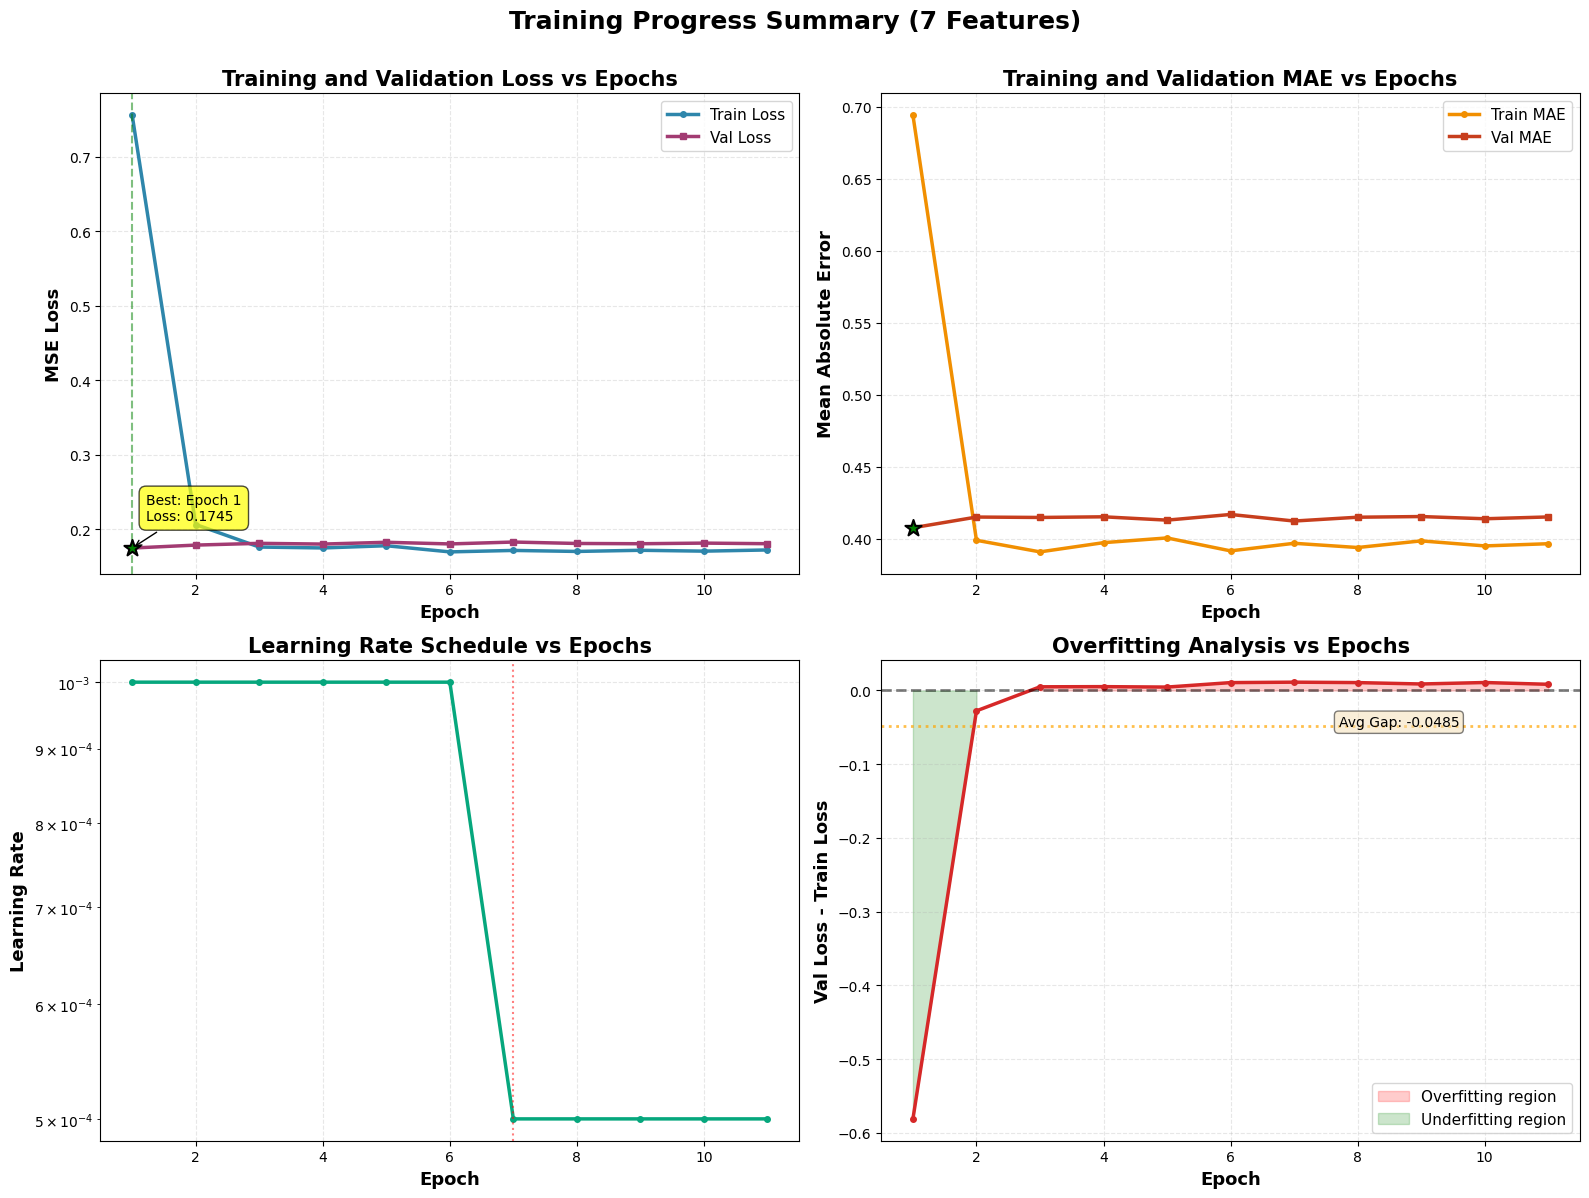

📈 Plots displayed above!

📈 FINAL SUMMARY
Best validation loss: 0.1745
Best validation MAE: 0.4075
Final train loss: 0.1719
Final val loss: 0.1803
Total epochs trained: 11

💡 To use the trained model:
   1. Load model: torch.load('argument_quality_ffn_7features.pth')
   2. Load normalization stats for inference
   3. Normalize input features before prediction
   4. Use only 7 features (no max_logprob, no min_logprob)

✅ Training complete!


In [6]:
"""
Complete FFN Training Loop - Modified for 7 Features
Trains the argument quality evaluation model without max_logprob and min_logprob
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os


# ============================================================
# Model (Updated for 7 features)
# ============================================================

class LogicEvaluationModel(nn.Module):
    def __init__(self, input_dim: int = 7, dropout_rate: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, 16),
            nn.LayerNorm(16),
            nn.ReLU(),
            
            nn.Linear(16, 1)   # Linear output for regression
        )
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.net(x)


# ============================================================
# Feature Normalization (7 features)
# ============================================================

def normalize_features(features: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
    """
    Normalize features with special handling for avg_logprob and avg_entropy
    
    Feature order (7 features total):
    0: avg_logprob         → Normalize (negative values)
    1: relevance_support   → Already 0-1, no normalization
    2: relevance_contra    → Already 0-1, no normalization
    3: similarity          → Already 0-1, no normalization
    4: confidence          → Already 0-1, no normalization
    5: repetition          → Already 0-1, no normalization
    6: avg_entropy         → Normalize (positive values)
    
    REMOVED: max_logprob (previously index 6)
    REMOVED: min_logprob (previously index 7)
    
    Returns:
        normalized_features, normalization_stats
    """
    
    normalized = features.clone()
    stats = {}
    
    # Feature 0: avg_logprob (typically -10 to 0)
    # Use min-max normalization to [0, 1]
    avg_logprob = features[:, 0]
    min_val = avg_logprob.min()
    max_val = avg_logprob.max()
    normalized[:, 0] = (avg_logprob - min_val) / (max_val - min_val + 1e-8)
    stats['avg_logprob'] = {'min': min_val.item(), 'max': max_val.item()}
    
    # Features 1-5: Already normalized to [0, 1], keep as is
    # (relevance_support, relevance_contra, similarity, confidence, repetition)
    
    # Feature 6: avg_entropy (typically 0 to 10)
    # Use min-max normalization to [0, 1]
    avg_entropy = features[:, 6]
    min_val = avg_entropy.min()
    max_val = avg_entropy.max()
    normalized[:, 6] = (avg_entropy - min_val) / (max_val - min_val + 1e-8)
    stats['avg_entropy'] = {'min': min_val.item(), 'max': max_val.item()}
    
    return normalized, stats


# ============================================================
# Feature Extraction (Remove max_logprob and min_logprob)
# ============================================================

def extract_7_features(features_9: torch.Tensor) -> torch.Tensor:
    """
    Extract 7 features from the original 9-feature tensor by removing
    max_logprob (index 6) and min_logprob (index 7).
    
    Original 9 features:
    0: avg_logprob
    1: relevance_support
    2: relevance_contra
    3: similarity
    4: confidence
    5: repetition
    6: max_logprob (REMOVE)
    7: min_logprob (REMOVE)
    8: avg_entropy
    
    New 7 features:
    0: avg_logprob
    1: relevance_support
    2: relevance_contra
    3: similarity
    4: confidence
    5: repetition
    6: avg_entropy (moved from index 8)
    """
    # Keep features [0-5] and [8], dropping [6] and [7]
    indices = [0, 1, 2, 3, 4, 5, 8]
    return features_9[:, indices]


# ============================================================
# Training Loop
# ============================================================

def train_ffn(
    data_path: str = "training_data.pt",
    save_path: str = "argument_quality_ffn.pth",
    batch_size: int = 32,
    epochs: int = 50,
    learning_rate: float = 0.001,
    val_split: float = 0.2,
    early_stopping: int = 10,
    input_dim: int = 7
):
    """
    Complete training pipeline with normalization (7 features)
    
    Args:
        data_path: Path to training data
        save_path: Where to save trained model
        batch_size: Batch size for training
        epochs: Maximum number of epochs
        learning_rate: Learning rate
        val_split: Validation split ratio
        early_stopping: Early stopping patience
        input_dim: Number of input features (7 for reduced feature set)
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🎯 Training on: {device}")
    print(f"📊 Input features: {input_dim}\n")
    
    # Load data
    print("📦 Loading data...")
    data = torch.load(data_path)
    
    # Extract features and labels
    features = torch.stack([item[0] for item in data])
    labels = torch.tensor([item[1] for item in data], dtype=torch.float32)
    
    print(f"   Loaded {len(data)} samples")
    print(f"   Original feature shape: {features.shape}")
    print(f"   Label shape: {labels.shape}")
    
    # Convert from 9 features to 7 features if needed
    if features.shape[1] == 9:
        print("\n🔧 Converting from 9 features to 7 features...")
        print("   Removing: max_logprob (index 6), min_logprob (index 7)")
        features = extract_7_features(features)
        print(f"   New feature shape: {features.shape}")
    elif features.shape[1] != input_dim:
        print(f"⚠️  Warning: Expected {input_dim} features, got {features.shape[1]}")
        print(f"   Adjusting input_dim to {features.shape[1]}")
        input_dim = features.shape[1]
    
    # Normalize features
    print("\n🔧 Normalizing features...")
    print("   Features to normalize:")
    print("   - Feature 0: avg_logprob")
    print("   - Feature 6: avg_entropy")
    print("   Features already normalized (0-1):")
    print("   - Features 1-5: relevance_support, relevance_contra, similarity, confidence, repetition")
    
    normalized_features, norm_stats = normalize_features(features)
    
    print("\n📊 Normalization Statistics:")
    for feature_name, stats in norm_stats.items():
        print(f"   {feature_name}:")
        print(f"      Original range: [{stats['min']:.4f}, {stats['max']:.4f}]")
        print(f"      Normalized to: [0, 1]")
    
    # Save normalization stats
    norm_stats_path = save_path.replace('.pth', '_norm_stats.pt')
    torch.save(norm_stats, norm_stats_path)
    print(f"\n💾 Normalization stats saved to: {norm_stats_path}")
    
    # Create dataset
    dataset = TensorDataset(normalized_features, labels)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    
    train_dataset, val_dataset = random_split(
        dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # Reproducibility
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"\n📊 Data Split:")
    print(f"   Train: {train_size} samples ({len(train_loader)} batches)")
    print(f"   Val: {val_size} samples ({len(val_loader)} batches)")
    
    # Initialize model
    model = LogicEvaluationModel(input_dim=input_dim).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n🤖 Model Architecture:")
    print(f"   Input({input_dim}) → 64 → 32 → 16 → 1")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: {total_params * 4 / (1024**2):.2f} MB")
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=0.01  # L2 regularization
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        patience=5, 
        factor=0.5
    )
    
    # Training history
    history = {
        'train_loss': [], 
        'val_loss': [], 
        'train_mae': [], 
        'val_mae': [],
        'learning_rates': []
    }
    best_val_loss = float('inf')
    patience_counter = 0
    
    print("\n" + "="*80)
    print("🚀 TRAINING STARTED")
    print("="*80 + "\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_mae = 0, 0
        
        for features_batch, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            features_batch = features_batch.to(device)
            labels_batch = labels_batch.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(features_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_mae += torch.abs(outputs - labels_batch).mean().item()
        
        train_loss /= len(train_loader)
        train_mae /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss, val_mae = 0, 0
        
        with torch.no_grad():
            for features_batch, labels_batch in val_loader:
                features_batch = features_batch.to(device)
                labels_batch = labels_batch.to(device).unsqueeze(1)
                
                outputs = model(features_batch)
                loss = criterion(outputs, labels_batch)
                
                val_loss += loss.item()
                val_mae += torch.abs(outputs - labels_batch).mean().item()
        
        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        
        # Update scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)
        history['learning_rates'].append(current_lr)
        
        # Print progress
        print(f"Epoch {epoch+1:3d}/{epochs} | "
              f"Train Loss: {train_loss:.4f} MAE: {train_mae:.4f} | "
              f"Val Loss: {val_loss:.4f} MAE: {val_mae:.4f} | "
              f"LR: {current_lr:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            # Save model with normalization stats
            torch.save({
                'model_state_dict': model.state_dict(),
                'input_dim': input_dim,
                'normalization_stats': norm_stats,
                'best_val_loss': best_val_loss,
                'epoch': epoch + 1
            }, save_path)
            
            print(f"   💾 Best model saved! (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{early_stopping})")
        
        # Early stopping
        if patience_counter >= early_stopping:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            break
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETED")
    print("="*80)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Model saved to: {save_path}")
    print("="*80 + "\n")
    
    # Plot training history
    plot_training_history(history, save_path='training_history.png')
    
    return model, history, norm_stats


# ============================================================
# Visualization
# ============================================================

def plot_training_history(history: Dict, save_path: str = 'training_history.png'):
    """Plot training history with enhanced visualization"""
    
    print("\n📊 Generating training visualization plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # ========================================
    # Plot 1: Training and Validation Loss
    # ========================================
    axes[0, 0].plot(epochs, history['train_loss'], 
                    label='Train Loss', linewidth=2.5, color='#2E86AB', marker='o', markersize=4)
    axes[0, 0].plot(epochs, history['val_loss'], 
                    label='Val Loss', linewidth=2.5, color='#A23B72', marker='s', markersize=4)
    axes[0, 0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[0, 0].set_ylabel('MSE Loss', fontsize=13, fontweight='bold')
    axes[0, 0].set_title('Training and Validation Loss vs Epochs', fontsize=15, fontweight='bold')
    axes[0, 0].legend(fontsize=11, loc='best')
    axes[0, 0].grid(True, alpha=0.3, linestyle='--')
    
    # Mark best epoch
    best_epoch = np.argmin(history['val_loss']) + 1
    best_val_loss = min(history['val_loss'])
    axes[0, 0].axvline(x=best_epoch, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
    axes[0, 0].scatter([best_epoch], [best_val_loss], color='green', s=150, zorder=5, 
                       marker='*', edgecolors='black', linewidths=1.5)
    axes[0, 0].annotate(f'Best: Epoch {best_epoch}\nLoss: {best_val_loss:.4f}',
                       xy=(best_epoch, best_val_loss), xytext=(10, 20),
                       textcoords='offset points', fontsize=10,
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # ========================================
    # Plot 2: Training and Validation MAE
    # ========================================
    axes[0, 1].plot(epochs, history['train_mae'], 
                    label='Train MAE', linewidth=2.5, color='#F18F01', marker='o', markersize=4)
    axes[0, 1].plot(epochs, history['val_mae'], 
                    label='Val MAE', linewidth=2.5, color='#C73E1D', marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[0, 1].set_ylabel('Mean Absolute Error', fontsize=13, fontweight='bold')
    axes[0, 1].set_title('Training and Validation MAE vs Epochs', fontsize=15, fontweight='bold')
    axes[0, 1].legend(fontsize=11, loc='best')
    axes[0, 1].grid(True, alpha=0.3, linestyle='--')
    
    # Mark best MAE
    best_mae_epoch = np.argmin(history['val_mae']) + 1
    best_val_mae = min(history['val_mae'])
    axes[0, 1].scatter([best_mae_epoch], [best_val_mae], color='green', s=150, zorder=5,
                       marker='*', edgecolors='black', linewidths=1.5)
    
    # ========================================
    # Plot 3: Learning Rate Schedule
    # ========================================
    axes[1, 0].plot(epochs, history['learning_rates'], 
                    linewidth=2.5, color='#06A77D', marker='o', markersize=4)
    axes[1, 0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[1, 0].set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
    axes[1, 0].set_title('Learning Rate Schedule vs Epochs', fontsize=15, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3, linestyle='--')
    
    # Add text annotation for LR changes
    lr_changes = []
    for i in range(1, len(history['learning_rates'])):
        if history['learning_rates'][i] != history['learning_rates'][i-1]:
            lr_changes.append(i+1)
    
    for epoch_num in lr_changes[:3]:  # Annotate first 3 LR changes
        axes[1, 0].axvline(x=epoch_num, color='red', linestyle=':', alpha=0.5, linewidth=1.5)
    
    # ========================================
    # Plot 4: Overfitting Analysis
    # ========================================
    gap = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 1].plot(epochs, gap, linewidth=2.5, color='#D62828', marker='o', markersize=4)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=2)
    axes[1, 1].fill_between(epochs, 0, gap, where=(gap > 0), 
                            color='red', alpha=0.2, label='Overfitting region')
    axes[1, 1].fill_between(epochs, 0, gap, where=(gap <= 0), 
                            color='green', alpha=0.2, label='Underfitting region')
    axes[1, 1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[1, 1].set_ylabel('Val Loss - Train Loss', fontsize=13, fontweight='bold')
    axes[1, 1].set_title('Overfitting Analysis vs Epochs', fontsize=15, fontweight='bold')
    axes[1, 1].legend(fontsize=11, loc='best')
    axes[1, 1].grid(True, alpha=0.3, linestyle='--')
    
    # Add average gap line
    avg_gap = np.mean(gap)
    axes[1, 1].axhline(y=avg_gap, color='orange', linestyle=':', alpha=0.7, linewidth=2)
    axes[1, 1].text(len(epochs)*0.7, avg_gap, f'Avg Gap: {avg_gap:.4f}',
                   fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Overall figure title
    fig.suptitle('Training Progress Summary (7 Features)', fontsize=18, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
    print(f"✅ Training plots saved to: {save_path}")
    
    # Display plot (will show in Jupyter/Colab)
    try:
        plt.show()
        print("📈 Plots displayed above!")
    except:
        print("💡 Open the saved image to view plots")
    finally:
        plt.close()


# ============================================================
# Main Execution
# ============================================================

if __name__ == "__main__":
    
    # Configuration
    CONFIG = {
        'data_path': "/kaggle/working/training_data.pt",
        'save_path': "logic_evaluation_model.pth",
        'batch_size': 32,
        'epochs': 50,
        'learning_rate': 0.001,
        'val_split': 0.2,
        'early_stopping': 10,
        'input_dim': 7  # Updated to 7 features (removed max_logprob and min_logprob)
    }
    
    print("🧠 FFN Training with 7 Features")
    print("="*80)
    print("\n📋 Configuration:")
    for key, value in CONFIG.items():
        print(f"   {key}: {value}")
    print("\n🔧 Feature Set (7 features):")
    print("   0: avg_logprob")
    print("   1: relevance_support")
    print("   2: relevance_contra")
    print("   3: similarity")
    print("   4: confidence")
    print("   5: repetition")
    print("   6: avg_entropy")
    print("\n❌ REMOVED:")
    print("   - max_logprob")
    print("   - min_logprob")
    print("="*80)
    
    # Train model
    model, history, norm_stats = train_ffn(**CONFIG)
    
    # Print final summary
    print("\n" + "="*80)
    print("📈 FINAL SUMMARY")
    print("="*80)
    print(f"Best validation loss: {min(history['val_loss']):.4f}")
    print(f"Best validation MAE: {min(history['val_mae']):.4f}")
    print(f"Final train loss: {history['train_loss'][-1]:.4f}")
    print(f"Final val loss: {history['val_loss'][-1]:.4f}")
    print(f"Total epochs trained: {len(history['train_loss'])}")
    print("="*80)
    
    print("\n💡 To use the trained model:")
    print("   1. Load model: torch.load('argument_quality_ffn_7features.pth')")
    print("   2. Load normalization stats for inference")
    print("   3. Normalize input features before prediction")
    print("   4. Use only 7 features (no max_logprob, no min_logprob)")
    print("\n✅ Training complete!")